In [ ]:
from google.colab import files
uploaded = files.upload()

Saving hymenoptera_data.zip to hymenoptera_data.zip


In [ ]:
!unzip hymenoptera_data.zip

In [5]:
# notebook imports

from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [6]:
# pytorch imputs

import torch 
from torch import Tensor

import torch.nn as nn
import torch.optim as optim

from torch.optim import lr_scheduler
from torch.nn import Module, Sigmoid, Linear, ReLU, Softmax

from torch.utils.data import Dataset, random_split, DataLoader
from torch.optim import SGD
from torch.nn.init import kaiming_uniform_, xavier_uniform_
from torch.nn import CrossEntropyLoss, BCELoss

import torchvision
from torchvision import datasets,transforms,models

plt.ion()

In [7]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [8]:
# carrying out the preprocessing 

data_dir = '/content/hymenoptera_data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [10]:
# utlity function to plot a tensor i.e. image

def plotImage(inp,title=None):
    # inp is a tensor
    inp=inp.numpy().transpose((1,2,0))
    mean=np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause so that the plots get updated


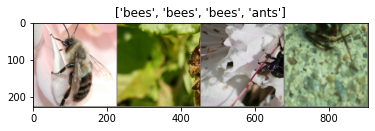

In [13]:
# visualising some images

inputs,classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)

plotImage(out,title=[class_names[x] for x in classes])

In [21]:
# utility function for training a model

def train_model(model,criterion,optimizer,scheduler,num_epochs=25):

    since = time.time() # starting time

    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch,num_epochs-1))
        print('-'*20)

        # training and validation phase of each epoch
        for phase in ['train','val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            # iterate over data
            for inputs,labels in dataloaders[phase]:
                inputs=inputs.to(device)
                labels=labels.to(device)

                # set param gradients to zero
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _,preds = torch.max(outputs,1)
                    loss = criterion(outputs,labels)

                    #backward - optimise only if train
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # stats
                running_loss += loss.item() * inputs.size(0)
                running_corrects +=torch.sum(preds==labels.data)

            
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss/dataset_sizes[phase]
            epoch_acc = running_corrects.double()/dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase,epoch_loss,epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())
            
        print()

    time_elapsed = time.time() - since

    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60,time_elapsed%60))
    print('Best validation accuracy: {:.4f}'.format(best_acc))

    model.load_state_dict(best_model_weights)

    return model


In [22]:
# utility function to visualise few predictions made by model

def plot_model_preds(model,num_images=6):

    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        
        for i,(inputs,labels) in enumerate(dataloaders['val']):
            inputs=inputs.to(device)
            labels=labels.to(device)

            outputs = model(inputs)
            _,preds=torch.max(outputs,1)

            for j in range(inputs.size()[0]):
                
                images_so_far += 1
                
                ax = plt.subplot(num_images//2,2,images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                plotImage(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        
        model.train(mode=was_training)


In [23]:
# loading a pre-trained model and reset the final layer

model_ft = models.resnet18(pretrained=True)

num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized by :
# nn.Linear(num_ftrs, len(class_names))

model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# all params being optimized

optimizer_ft = optim.SGD(model_ft.parameters(),
                         lr=0.001,
                         momentum=0.9)

# decay learning rate by factor of 0.1 every 7 epochs

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft,
                                       step_size=7,
                                       gamma=0.1)


In [24]:
# Train and evaluate the model

model_ft = train_model(model_ft,
                       criterion,
                       optimizer_ft,
                       exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
--------------------
train Loss: 0.6907 Acc: 0.6557
val Loss: 0.2257 Acc: 0.8954

Epoch 1/24
--------------------
train Loss: 0.4951 Acc: 0.8074
val Loss: 0.3512 Acc: 0.8431

Epoch 2/24
--------------------
train Loss: 0.4877 Acc: 0.8115
val Loss: 0.3403 Acc: 0.8627

Epoch 3/24
--------------------
train Loss: 0.4428 Acc: 0.8197
val Loss: 0.2481 Acc: 0.9150

Epoch 4/24
--------------------
train Loss: 0.3030 Acc: 0.8607
val Loss: 0.2467 Acc: 0.9216

Epoch 5/24
--------------------
train Loss: 0.4849 Acc: 0.8443
val Loss: 0.2160 Acc: 0.9085

Epoch 6/24
--------------------
train Loss: 0.5139 Acc: 0.8238
val Loss: 0.2607 Acc: 0.8693

Epoch 7/24
--------------------
train Loss: 0.3248 Acc: 0.8607
val Loss: 0.1913 Acc: 0.9412

Epoch 8/24
--------------------
train Loss: 0.3445 Acc: 0.8361
val Loss: 0.2038 Acc: 0.9346

Epoch 9/24
--------------------
train Loss: 0.3780 Acc: 0.8361
val Loss: 0.2210 Acc: 0.9216

Epoch 10/24
--------------------
train Loss: 0.3006 Acc: 0.8811
val Lo

In [ ]:
plot_model_preds(model_ft,num_images=10)